# Transfert learning avec TensorFlow

## Introduction

Dans ce notebook, nous allons explorer le concept de transfert learning en utilisant TensorFlow.

### Objectif

L'objectif de ce notebook est de :

1. Comprendre le concept de transfert learning.
2. Implémenter le transfert learning en utilisant un modèle pré-entraîné dans TensorFlow.
3. Affiner le modèle pré-entraîné sur un ensemble de données personnalisé.

### 1. Importation des bibliothèques et chargement des données

Commençons par importer les bibliothèques nécessaires et charger notre ensemble de données. Pour cet exemple, nous utiliserons l'ensemble de données suivant:
https://www.kaggle.com/datasets/rhammell/ships-in-satellite-imagery/data

L'archive contient un fichier .json décrivant les données.
A partir du fichier .json, construisez un dataset Tensorflow. Pour cela :
1. Ouvrez le fichier .json, explorez les données.
2. Les données correspondant aux images contiennent successivement 3 canaux. Réorganisez les dimensions des images pour pouvoir les utiliser dans un dataset.
3. Récupérez les labels. Encodez les en one-hot.
4. Construisez le dataset, et préparez le pour l'entrainement.


In [1]:
!pip install tensorflow

In [2]:
import json
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os

In [6]:
import zipfile
zipfile.ZipFile('/content/shipsnet.json.zip').extractall('/content/')

In [7]:
FILE_PATH = '/content/shipsnet.json'
# Constantes pour les images et le dataset
IMG_WIDTH = 80
IMG_HEIGHT = 80
CHANNELS = 3
BATCH_SIZE = 32
NUM_CLASSES = 2

In [8]:

try:
    with open(FILE_PATH, 'r') as f:
        raw_data = json.load(f)
except FileNotFoundError:
    print(f"ERREUR : Le fichier '{FILE_PATH}' n'a pas été trouvé.")
    print("Veuillez télécharger l'archive Kaggle, la dézipper et mettre à jour la variable FILE_PATH.")
    # Dans un script réel, vous arrêteriez l'exécution ici.
    # Pour cet exemple, nous levons l'erreur.
    raise


In [9]:
images_flat = np.array(raw_data['data'], dtype=np.float32)
labels_raw = np.array(raw_data['labels'], dtype=np.int32)

print(f"Shape des images (aplaties) : {images_flat.shape}")
print(f"Shape des labels (bruts) : {labels_raw.shape}")

images_reshaped = images_flat.reshape(-1, CHANNELS, IMG_HEIGHT, IMG_WIDTH)

images_tf_format = np.transpose(images_reshaped, (0, 2, 3, 1))

images_normalized = images_tf_format / 255.0

print(f"Shape des images (format TF normalisé) : {images_normalized.shape}")
labels_one_hot = tf.keras.utils.to_categorical(labels_raw, num_classes=NUM_CLASSES)

Shape des images (aplaties) : (4000, 19200)
Shape des labels (bruts) : (4000,)
Shape des images (format TF normalisé) : (4000, 80, 80, 3)


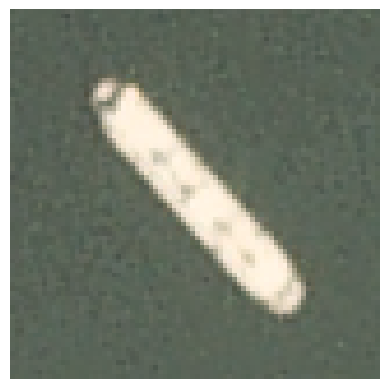

In [10]:
def print_image(image):
    plt.imshow(image.astype('uint8'))
    plt.axis('off')
    plt.show()
print_image(images_tf_format[0])

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    images_normalized,
    labels_one_hot,
    test_size=0.20,
    random_state=42,
    stratify=labels_one_hot
)

print(f"  Taille de l'ensemble d'entraînement : {X_train.shape[0]} images")
print(f"  Taille de l'ensemble de validation : {X_val.shape[0]} images")
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(len(X_train)) \
                             .batch(BATCH_SIZE) \
                             .prefetch(buffer_size=tf.data.AUTOTUNE)

# Création du dataset de validation
# (Pas besoin de .shuffle() pour la validation)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.batch(BATCH_SIZE) \
                         .prefetch(buffer_size=tf.data.AUTOTUNE)

  Taille de l'ensemble d'entraînement : 3200 images
  Taille de l'ensemble de validation : 800 images


# Chargement du modèle préentrainé

In [12]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

INPUT_SHAPE = (80, 80, 3)
NUM_CLASSES = 2
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=INPUT_SHAPE
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


### 3. Construction et compilation du modèle

Intégrez le modèle de ResNet50 dans un modèle final en rajoutant une couche de GlobalAveragePooling2D et deux couches Dense, puis compilez le modèle.

In [13]:
base_model.trainable = False
inputs = Input(shape=INPUT_SHAPE)
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(NUM_CLASSES, activation='softmax')(x)
model = Model(inputs=inputs, outputs=outputs)
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',     metrics=['accuracy']
)
print("\n--- Résumé du modèle final ---")
model.summary()


--- Résumé du modèle final ---


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 80, 80, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 3, 3, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,242 (90.98 MB)

 Trainable params: 262,530 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

### 4. Entrainement et visualisation des résultats

Entrainez le modèle final pour 10 epochs, puis visualisez les courbes d'accuracy et de loss.

In [15]:
EPOCHS = 10
print(f"\nDébut de l'entraînement pour {EPOCHS} époques...")
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    verbose=1
)


Début de l'entraînement pour 10 époques...
Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 34s 62ms/step - accuracy: 0.8054 - loss: 0.4714 - val_accuracy: 0.8612 - val_loss: 0.3450
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.8461 - loss: 0.3637 - val_accuracy: 0.8725 - val_loss: 0.3118
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.8377 - loss: 0.3596 - val_accuracy: 0.8800 - val_loss: 0.2808
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.8564 - loss: 0.3329 - val_accuracy: 0.8925 - val_loss: 0.2594
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.8713 - loss: 0.2959 - val_accuracy: 0.8975 - val_loss: 0.2518
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.8855 - loss: 0.2707 - val_accuracy: 0.8637 - val_loss: 0.3171
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.8781 - loss: 0.2912 - val_accuracy: 0.9000 - val_loss: 0.2368
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step

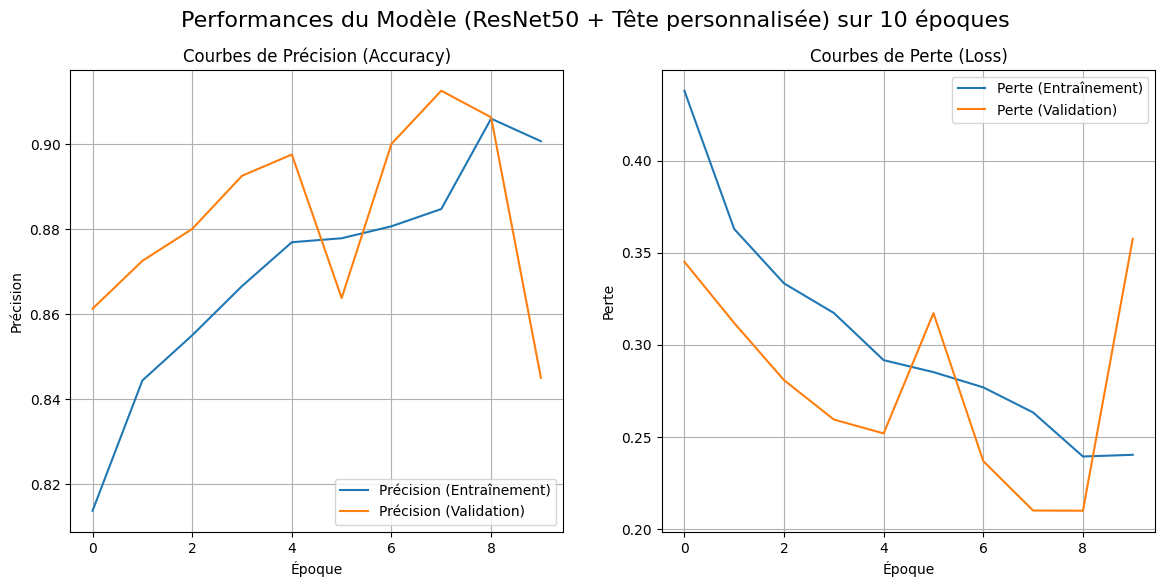

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(EPOCHS)
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Précision (Entraînement)")
plt.plot(epochs_range, val_acc, label="Précision (Validation)")
plt.legend(loc='lower right')
plt.title("Courbes de Précision (Accuracy)")
plt.xlabel('Époque')
plt.ylabel('Précision')
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Perte (Entraînement)")
plt.plot(epochs_range, val_loss, label="Perte (Validation)")
plt.legend(loc='upper right')
plt.title("Courbes de Perte (Loss)")
plt.xlabel('Époque')
plt.ylabel('Perte')
plt.grid(True)
plt.suptitle(f"Performances du Modèle (ResNet50 + Tête personnalisée) sur {EPOCHS} époques", fontsize=16)
plt.show()

### 5. Fine-tuning des paramètres

Décongelez les poids des deux dernières couches de convolution de ResNet50, puis recompilez le modèle final et poursuivez l'entrainement pour 5 epochs de plus

In [17]:
base_model.trainable = True
unfreeze_from_name = 'conv5_block2_1_conv'

set_trainable = False
for layer in base_model.layers:
    if layer.name == unfreeze_from_name:
        set_trainable = True  # Tout ce qui suit sera décongelé

    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

print(f"Couches du 'base_model' décongelées à partir de : {unfreeze_from_name}")

LOW_LEARNING_RATE = 1e-5

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LOW_LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(f"Modèle recompilé avec un optimiseur Adam (LR={LOW_LEARNING_RATE})")
model.summary()
try:
    initial_epoch = history.epoch[-1] + 1
    previous_epochs = len(history.epoch)
except NameError:
    print("\nVariable 'history' non trouvée. Réglage manuel à 10 époques.")
    initial_epoch = 10
    previous_epochs = 10


Couches du 'base_model' décongelées à partir de : conv5_block2_1_conv
Modèle recompilé avec un optimiseur Adam (LR=1e-05)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 80, 80, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 3, 3, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,242 (90.98 MB)

 Trainable params: 9,193,858 (35.07 MB)

 Non-trainable params: 14,656,384 (55.91 MB)

In [18]:
FINE_TUNE_EPOCHS = 5
TOTAL_EPOCHS = previous_epochs + FINE_TUNE_EPOCHS

print(f"\nDébut du fine-tuning... (de l'époque {initial_epoch} à {TOTAL_EPOCHS})")
history_fine = model.fit(
    train_dataset,
    epochs=TOTAL_EPOCHS,
    initial_epoch=initial_epoch,
    validation_data=val_dataset
)


Début du fine-tuning... (de l'époque 10 à 15)
Epoch 11/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 54s 124ms/step - accuracy: 0.8809 - loss: 0.6864 - val_accuracy: 0.8662 - val_loss: 0.2850
Epoch 12/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9430 - loss: 0.1311 - val_accuracy: 0.8263 - val_loss: 0.5267
Epoch 13/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9769 - loss: 0.0657 - val_accuracy: 0.8938 - val_loss: 0.2768
Epoch 14/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.9719 - loss: 0.0707 - val_accuracy: 0.9225 - val_loss: 0.2633
Epoch 15/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9802 - loss: 0.0555 - val_accuracy: 0.9725 - val_loss: 0.0836


In [24]:
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

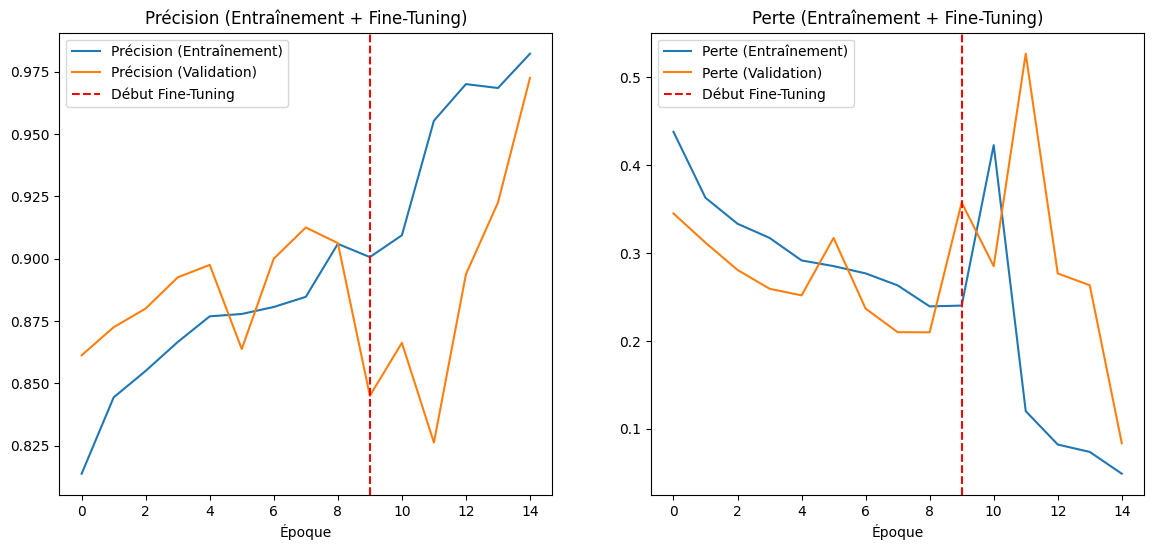

In [25]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Précision (Entraînement)')
plt.plot(val_acc, label='Précision (Validation)')
# Ajoute une ligne verticale pour marquer le début du fine-tuning
plt.axvline(previous_epochs - 1, color='red', linestyle='--', label='Début Fine-Tuning')
plt.legend()
plt.title('Précision (Entraînement + Fine-Tuning)')
plt.xlabel('Époque')

# Courbes de Perte
plt.subplot(1, 2, 2)
plt.plot(loss, label='Perte (Entraînement)')
plt.plot(val_loss, label='Perte (Validation)')
# Ajoute une ligne verticale pour marquer le début du fine-tuning
plt.axvline(previous_epochs - 1, color='red', linestyle='--', label='Début Fine-Tuning')
plt.legend()
plt.title('Perte (Entraînement + Fine-Tuning)')
plt.xlabel('Époque')

plt.show()